# Computing the Conditional Average Treatment Effect (CATE) with Bayesian Neural Networks

In [1]:
%%bash
pip install torchview
pip install git+https://github.com/arose13/ConcreteDropout.git

  Cloning https://github.com/arose13/ConcreteDropout.git to /tmp/pip-req-build-fmhx96su
  Resolved https://github.com/arose13/ConcreteDropout.git to commit 935f59d68bfae2d760186c0eca313d35cb6a6a82
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/arose13/ConcreteDropout.git /tmp/pip-req-build-fmhx96su


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as graph
from scipy import stats
from scipy.special import expit
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm, trange
from condrop import ConcreteDropout, concrete_regulariser
from torchview import draw_graph
from IPython.display import Markdown
graph.style.use('fivethirtyeight')
graph.rcParams['lines.linewidth'] = 1

In [3]:
# Setup quick fake data
n, p = int(1e4), 20
treatment_effect = 0.5

m = stats.norm().rvs(p)
x = stats.norm().rvs((n, p))
# treatment_labels = stats.bernoulli(0.2).rvs(n)  # Random assignment (Unconfounded)
treatment_labels = expit((x[:, :5] @ m[:5]) + 2*stats.norm().rvs(n)).round()  # Conditional assignment (Confounding)

y = x@m + treatment_effect*treatment_labels + stats.norm().rvs(n)

print(x.shape, y.shape, treatment_labels.shape)

(10000, 20) (10000,) (10000,)


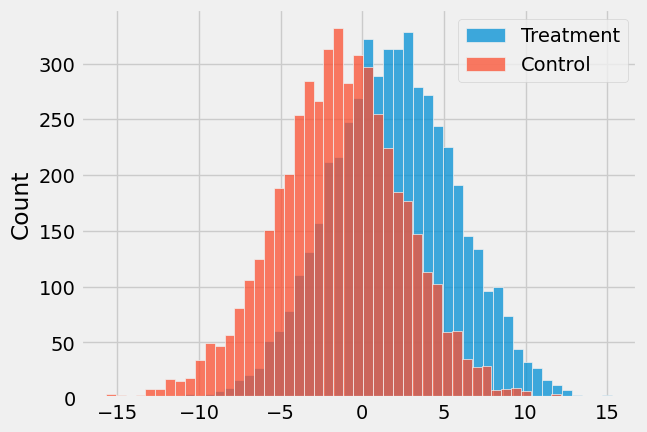

True Treatment Effect = 0.5
Naive Estimate of the Treatment Effect = 3.316012


In [4]:
# Naive Estimate
sns.histplot(y[treatment_labels.astype(bool)], label='Treatment')
sns.histplot(y[~treatment_labels.astype(bool)], label='Control')
graph.legend()
graph.show()

control_mean = y[~treatment_labels.astype(bool)].mean()
treatment_mean = y[treatment_labels.astype(bool)].mean()
naive_causal_estimate = treatment_mean - control_mean

print(f'True Treatment Effect = {treatment_effect}')
print(f'Naive Estimate of the Treatment Effect = {naive_causal_estimate:2f}')

$$CATE = {1 \over N} \sum [ f_{treatment}(x) - f_{control}(x) ] $$

$$J(\theta) = {1 \over N} \sum [ (f_{t_i}(x_i) - y_i)^2 + \mathcal{H}_{cross}(g(x_i), t_i) ] $$

By optimising $J(\theta)$ we are sure that we are optimising the CATE directly. This is both the model _must_ learn a covariate set in $Z$ that contains the information for estimating the propensity score. This should be _equivalent_ to adjusting for the propensity score.

In [5]:
# Specify the models
concrete_dropout_params = {
    'weight_regulariser': 1e-8,
    'dropout_regulariser': 1e-7,
}

@concrete_regulariser
class LatentModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=75):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.dnn_z = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.GELU(),
            nn.BatchNorm1d(output_dim),

        )
        self.cd_z = ConcreteDropout(**concrete_dropout_params)

    def forward(self, x):
        return self.cd_z(x, self.dnn_z)


@concrete_regulariser
class PropensityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.propensity = nn.Sequential(
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )
        self.cd_g = ConcreteDropout(**concrete_dropout_params)

    def forward(self, x):
        return self.cd_g(x, self.propensity)


@concrete_regulariser
class OutcomeModel(nn.Module):
    def __init__(self, hidden_dim=75):
        super().__init__()
        self.outcome_dnn = nn.Sequential(
            nn.LazyLinear(hidden_dim),
            nn.GELU(),
            nn.LazyLinear(1),
        )
        self.cd_o = ConcreteDropout(**concrete_dropout_params)

    def forward(self, x):
        return self.cd_o(x, self.outcome_dnn)

# Contruct the model
@concrete_regulariser
class CausalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # Required modules
        self.z_model = LatentModel(input_dim, 1)
        self.propensity_model = PropensityModel()
        self.q_given_treamtent = OutcomeModel()
        self.q_given_control = OutcomeModel()

    def forward(self, x):
        z = self.z_model(x)
        g = self.propensity_model(z)
        q_t = self.q_given_treamtent(z)
        q_c = self.q_given_control(z)
        return g, q_t, q_c, self.regularisation()

    def propensity(self, x):
        z = self.z_model(x)
        g = self.propensity_model(x)
        return g

    def q(self, x, given):
        z = self.z_model(x)
        if given.lower() == 't':
            return self.q_given_treamtent(x)
        elif given.lower() == 'c':
            return self.q_given_control(x)

    def ite(self, x):
        z = self.z_model(x)
        return self.q_given_treamtent(z) - self.q_given_control(z)

class CausalLoss(nn.modules.loss._Loss):
    def __init__(self):
        super().__init__()

    def forward(self, g_hat, is_treatment, qt_hat, qc_hat, y_true, regularization_penalty=0.0):
        # Q MSE terms
        treatment_mse = (is_treatment) * (qt_hat - y_true)**2
        control_mse = (1-is_treatment) * (qc_hat - y_true)**2
        q_mse = torch.mean(treatment_mse) + torch.mean(control_mse)

        # Binary cross entropy term
        g_entropy = F.binary_cross_entropy(g_hat, is_treatment)

        return q_mse + g_entropy + regularization_penalty

In [6]:
# Contruct the model
causal_model = CausalModel(p)
optimizer = torch.optim.Adam(causal_model.parameters(), lr=1e-3)
loss_func = CausalLoss()

# Prep model data
x_train, x_test, y_train, y_test, is_treatment_train, is_treatment_test = train_test_split(
    x, y, treatment_labels,
    test_size=0.2
)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1, 1)).float()
is_treatment_train = torch.from_numpy(is_treatment_train.reshape(-1, 1)).float()
is_treatment_test = torch.from_numpy(is_treatment_test.reshape(-1, 1)).float()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Model Summary

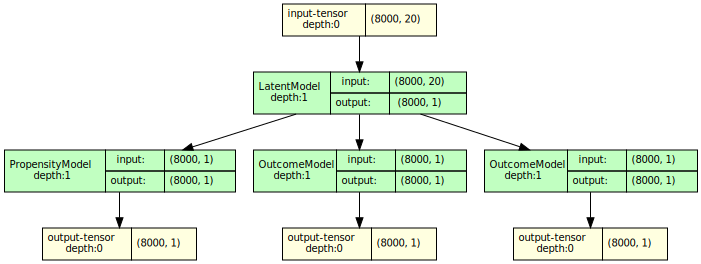

In [7]:
display(Markdown('## Model Summary'))
display(draw_graph(causal_model, input_size=x_train.shape, depth=1).visual_graph)

In [8]:
# Training loop
n_epochs = int(10e3)
hist = []
best_epoch = 0
best_loss = float('inf')
iterator = trange(n_epochs)
for epoch in iterator:
    # Forward pass
    g_hat, qt_hat, qc_hat, model_reg_penalty = causal_model(x_train)
    loss_i = loss_func(g_hat, is_treatment_train, qt_hat, qc_hat, y_train, model_reg_penalty)

    # Backward pass
    optimizer.zero_grad()
    loss_i.backward()
    optimizer.step()

    # Evaluate
    with torch.inference_mode():
        g_hat_test, qt_hat_test, qc_hat_test, _ = causal_model(x_test)
        hist.append((
            loss_func(
                g_hat_test,
                is_treatment_test,
                qt_hat_test,
                qc_hat_test,
                y_test
            ),
            torch.mean(causal_model.ite(x_test))
        ))
        iterator.set_description(f'i: {epoch:,} | loss: {hist[-1][0].numpy():.8f} | CATE: {hist[-1][1].numpy():.3f}')
        if hist[-1][0] < best_loss:
            best_loss = hist[-1][0]
            best_epoch = epoch
        elif (epoch - best_epoch) > 1000:
            print(f'Early stopping at epoch {epoch:,}')
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping at epoch 4,202


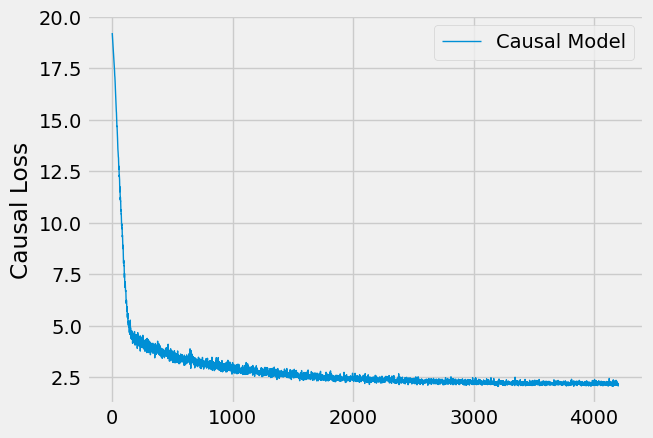

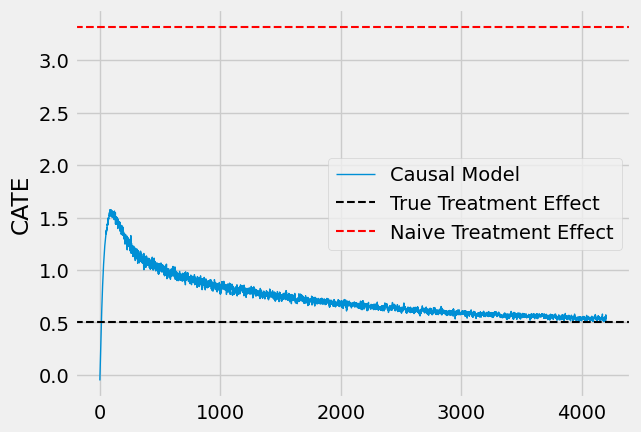

In [9]:
graph.plot(np.array([t[0].numpy() for t in hist]), label='Causal Model')
# graph.yscale('log')
graph.ylabel('Causal Loss')
graph.legend()
graph.show()

graph.plot(np.array([t[1].numpy() for t in hist]), label='Causal Model')
graph.axhline(treatment_effect, linestyle='--', color='black', lw=1.5, label='True Treatment Effect')
graph.axhline(naive_causal_estimate, linestyle='--', color='red', lw=1.5, label='Naive Treatment Effect')
graph.ylabel('CATE')
graph.legend()
graph.show()

_Stephen Anthony Rose_

In [10]:
# TODO predictive posterior sampling